In [1]:
import numpy as np 
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn import metrics
from math import sqrt
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
d=pd.read_csv('../input/bengaluru-house-price-data/Bengaluru_House_Data.csv')

In [3]:
d.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
d.describe().T

,count,mean,std,min,25%,50%,75%,max
bath,13247.0,2.692610,1.341458,1.0,2.0,2.0,3.0,40.0
balcony,12711.0,1.584376,0.817263,0.0,1.0,2.0,2.0,3.0
price,13320.0,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0


In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
area_type       13320 non-null object
availability    13320 non-null object
location        13319 non-null object
size            13304 non-null object
society         7818 non-null object
total_sqft      13320 non-null object
bath            13247 non-null float64
balcony         12711 non-null float64
price           13320 non-null float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [6]:
d.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [7]:
d['society'].shape

(13320,)

In [8]:
d['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', nan, '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [9]:
d.corr()

,bath,balcony,price
bath,1.000000,0.204201,0.456345
balcony,0.204201,1.000000,0.120355
price,0.456345,0.120355,1.000000


/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


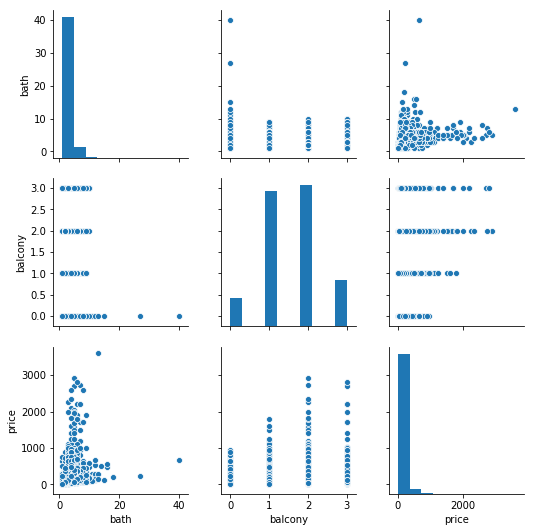

In [10]:
sns.pairplot(d)

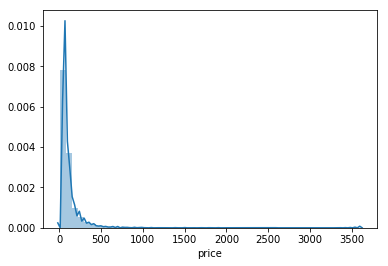

In [11]:
sns.distplot(d['price'])

In [12]:
d.select_dtypes(exclude=['object']).describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [13]:
corr=d.corr()

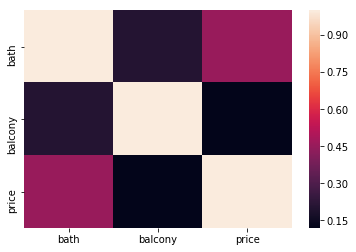

In [14]:
sns.heatmap(corr)

In [15]:
from collections import Counter
Counter(d['total_sqft'])

Counter({'1056': 12,
         '2600': 24,
         '1440': 23,
         '1521': 4,
         '1200': 843,
         '1170': 40,
         '2732': 3,
         '3300': 16,
         '1310': 37,
         '1020': 63,
         '1800': 104,
         '2785': 1,
         '1000': 172,
         '1100': 221,
         '2250': 13,
         '1175': 48,
         '1180': 58,
         '1540': 20,
         '2770': 3,
         '600': 180,
         '1755': 6,
         '2800': 28,
         '1767': 4,
         '510': 5,
         '1250': 114,
         '660': 20,
         '1610': 21,
         '1151': 12,
         '1025': 38,
         '2100 - 2850': 1,
         '1075': 66,
         '1760': 25,
         '1693': 9,
         '1925': 5,
         '700': 52,
         '1070': 53,
         '1724': 9,
         '1290': 37,
         '1143': 7,
         '1296': 12,
         '1254': 7,
         '1330.74': 1,
         '970': 13,
         '1459': 4,
         '800': 67,
         '869': 1,
         '1270': 41,
         '1670': 8,


In [16]:
d.shape

(13320, 9)

In [17]:
#preprocessing the total sqft cols as it has vivid entries
def preprocess_total_sqft(my_list):
    if len(my_list) == 1:
        
        try:
            return float(my_list[0])
        except:
            strings = ['Sq. Meter', 'Sq. Yards', 'Perch', 'Acres', 'Cents', 'Guntha', 'Grounds']
            split_list = re.split('(\d*.*\d)', my_list[0])[1:]
            area = float(split_list[0])
            type_of_area = split_list[1]
            
            if type_of_area == 'Sq. Meter':
                area_in_sqft = area * 10.7639
            elif type_of_area == 'Sq. Yards':
                area_in_sqft = area * 9.0
            elif type_of_area == 'Perch':
                area_in_sqft = area * 272.25
            elif type_of_area == 'Acres':
                area_in_sqft = area * 43560.0
            elif type_of_area == 'Cents':
                area_in_sqft = area * 435.61545
            elif type_of_area == 'Guntha':
                area_in_sqft = area * 1089.0
            elif type_of_area == 'Grounds':
                area_in_sqft = area * 2400.0
            return float(area_in_sqft)
        
    else:
        return (float(my_list[0]) + float(my_list[1]))/2.0

In [18]:
d['total_sqft'] = d.total_sqft.str.split('-').apply(preprocess_total_sqft)

In [19]:
#converting the categorical to numerical data - area_type
d.area_type.value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

In [20]:
replace_area_type = {'Super built-up  Area': 0, 'Built-up  Area': 1, 'Plot  Area': 2, 'Carpet  Area': 3}
d['area_type'] = d.area_type.map(replace_area_type)

In [21]:
#converting the categorical to numerical data - availabilty
d.availability.value_counts()

Ready To Move    10581
18-Dec             307
18-May             295
18-Apr             271
18-Aug             200
                 ...  
14-Nov               1
16-Jan               1
15-Jun               1
17-Jan               1
16-Oct               1
Name: availability, Length: 81, dtype: int64

In [22]:
def replace_availabilty(my_string):
    if my_string == 'Ready To Move':
        return 0
    elif my_string == 'Immediate Possession':
        return 1
    else:
        return 2

In [23]:
d['availability'] = d.availability.apply(replace_availabilty)

In [24]:
#converting NaN in location
d['location'].isnull().sum()

1

In [25]:
d['location'] = d['location'].fillna('No Location')

In [26]:
#converting the categorical to numerical data - size
Counter(d['size'])

Counter({'2 BHK': 5199,
         '4 Bedroom': 826,
         '3 BHK': 4310,
         '4 BHK': 591,
         '6 Bedroom': 191,
         '3 Bedroom': 547,
         '1 BHK': 538,
         '1 RK': 13,
         '1 Bedroom': 105,
         '8 Bedroom': 84,
         '2 Bedroom': 329,
         '7 Bedroom': 83,
         '5 BHK': 59,
         '7 BHK': 17,
         '6 BHK': 30,
         '5 Bedroom': 297,
         '11 BHK': 2,
         '9 BHK': 8,
         nan: 16,
         '9 Bedroom': 46,
         '27 BHK': 1,
         '10 Bedroom': 12,
         '11 Bedroom': 2,
         '10 BHK': 2,
         '19 BHK': 1,
         '16 BHK': 1,
         '43 Bedroom': 1,
         '14 BHK': 1,
         '8 BHK': 5,
         '12 Bedroom': 1,
         '13 BHK': 1,
         '18 Bedroom': 1})

In [27]:
le = LabelEncoder()
le.fit(d['size'].astype('str').append(d['size'].astype('str')))
d['size'] = le.transform(d['size'].astype('str'))

In [28]:
d.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,2,Electronic City Phase II,13,Coomee,1056.0,2.0,1.0,39.07
1,2,0,Chikka Tirupathi,19,Theanmp,2600.0,5.0,3.0,120.00
2,1,0,Uttarahalli,16,NaN,1440.0,2.0,3.0,62.00
3,0,0,Lingadheeranahalli,16,Soiewre,1521.0,3.0,1.0,95.00
4,0,0,Kothanur,13,NaN,1200.0,2.0,1.0,51.00


In [29]:
#converting the NaNs to other - society
d['society'] = d['society'].fillna('Other')

In [30]:
le.fit(d['society'].append(d['society'].fillna('Other')))
d['society'] = le.transform(d['society'])

In [31]:
#converting the categorical to numerical data - location
Counter(d['location'])

Counter({'Electronic City Phase II': 132,
         'Chikka Tirupathi': 17,
         'Uttarahalli': 186,
         'Lingadheeranahalli': 23,
         'Kothanur': 66,
         'Whitefield': 540,
         'Old Airport Road': 33,
         'Rajaji Nagar': 107,
         'Marathahalli': 175,
         'Gandhi Bazar': 2,
         '7th Phase JP Nagar': 149,
         'Gottigere': 48,
         'Sarjapur': 82,
         'Mysore Road': 50,
         'Bisuvanahalli': 51,
         'Raja Rajeshwari Nagar': 171,
         'Ramakrishnappa Layout': 7,
         'Manayata Tech Park': 8,
         'Kengeri': 73,
         'Binny Pete': 21,
         'Thanisandra': 234,
         'Bellandur': 96,
         ' Thanisandra': 3,
         'Mangammanapalya': 3,
         'Electronic City': 302,
         'Ramagondanahalli': 50,
         'Yelahanka': 213,
         'Hebbal': 177,
         'Kasturi Nagar': 16,
         'Kanakpura Road': 273,
         'Electronics City Phase 1': 88,
         'Kundalahalli': 47,
         'Chikkala

In [32]:
le.fit(d['location'].append(d['location'].fillna('other')))
d['location']=le.transform(d['location'])

In [33]:
#converting NaNs in bath
d['bath'].isna().sum()

73

In [34]:
#missing values are filled by grouping the rows based on location and taking the mean of the column 'bath' in that location.
col_bath=d.groupby('location')['bath'].transform(lambda x: x.fillna(x.mean()))

In [35]:
col_bath.isna().sum()

1

In [36]:
col_bath[~col_bath.notnull()]

1775   NaN
Name: bath, dtype: float64

In [37]:
#col 1775 has nan even after transformation
col_bath = col_bath.fillna(col_bath.mean())

In [38]:
#finally its resolved
col_bath.isnull().sum()

0

In [39]:
d['bath']=col_bath

In [40]:
#missing values are filled by grouping the rows based on location and taking the mean of the column 'balcony' in that location.
d['balcony'].isnull().sum()

609

In [41]:
col_balcony=d.groupby('location')['balcony'].transform(lambda x: x.fillna(x.mean()))

In [42]:
col_balcony.isna().sum()

45

In [43]:
#col 45 has nan even after transformation
col_balcony = col_balcony.fillna(col_balcony.mean())

In [44]:
col_balcony.isnull().sum()

0

In [45]:
d['balcony']=col_balcony

In [46]:
d.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,2,419,13,464,1056.0,2.0,1.0,39.07
1,2,0,317,19,2440,2600.0,5.0,3.0,120.00
2,1,0,1180,16,1447,1440.0,2.0,3.0,62.00
3,0,0,757,16,2187,1521.0,3.0,1.0,95.00
4,0,0,716,13,1447,1200.0,2.0,1.0,51.00


In [47]:
#preprocessing for building ML models
x=d.drop('price',axis=1)
y=d['price']

In [48]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
area_type       13320 non-null int64
availability    13320 non-null int64
location        13320 non-null int64
size            13320 non-null int64
society         13320 non-null int64
total_sqft      13320 non-null float64
bath            13320 non-null float64
balcony         13320 non-null float64
price           13320 non-null float64
dtypes: float64(4), int64(5)
memory usage: 936.7 KB


In [49]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=50)

In [50]:
#Linear Regression
lr=LinearRegression()

In [51]:
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
lpred=lr.predict(x_test)
print(lpred)

[220.31741453  73.89751785  64.72117456 ...  72.91288108  70.70540149
 149.56125905]


In [53]:
lrrmse=np.sqrt(np.mean((y_test-lpred)**2))
lrrmse

134.29557425653582

In [54]:
#Decision Tree
dt=DecisionTreeRegressor()

In [55]:
dt.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [56]:
dtpred=dt.predict(x_test)
print(dtpred)

[345.    39.12  52.   ...  40.14  75.   105.  ]


In [57]:
dtrmse=np.sqrt(np.mean((y_test-dtpred)**2))
dtrmse

135.9697229903218

In [58]:
#Random Forest
rf=RandomForestRegressor()

In [59]:
rf.fit(x_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [60]:
rfpred=rf.predict(x_test)
print(rfpred)

[461.          41.16941667  57.513      ...  57.445       56.013
  89.12666667]


In [61]:
rfrmse=np.sqrt(np.mean((y_test-rfpred)**2))
rfrmse

90.99104817218432